GPU available: []
🚀 Loading data...
train dataset pos sample count: 12500
train dataset neg sample count: 12500
train dataset label distribution: {0: 12500, 1: 12500}
test dataset pos sample count: 12500
test dataset neg sample count: 12500
test dataset label distribution: {0: 12500, 1: 12500}
Training sample count: 25000
Test sample count: 25000
🔧 Building text processor...
Vocabulary size: 30000
🛠 Building model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 300)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 300, 64)             │       1,920,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,988,129 (7.58 MB)

 Trainable params: 1,988,129 (7.58 MB)

 Non-trainable params: 0 (0.00 B)

🔥 Starting training...
Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 316s 398ms/step - accuracy: 0.7689 - loss: 0.5930 - val_accuracy: 0.5000 - val_loss: 0.7730
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 306s 392ms/step - accuracy: 0.6620 - loss: 0.5596 - val_accuracy: 0.5949 - val_loss: 0.6164
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 326s 417ms/step - accuracy: 0.8234 - loss: 0.4377 - val_accuracy: 0.8537 - val_loss: 0.3768
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 365s 395ms/step - accuracy: 0.9203 - loss: 0.2545 - val_accuracy: 0.8213 - val_loss: 0.4234
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 308s 393ms/step - accuracy: 0.9378 - loss: 0.1985 - val_accuracy: 0.8641 - val_loss: 0.3647
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 322s 394ms/step - accuracy: 0.9581 - loss: 0.1387 - val_accuracy: 0.8610 - val_loss: 0.3755
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 321s 410ms/step - accuracy: 0.9671 - loss: 0.1093 - val_accuracy: 0.8604 - val_loss: 0.3607
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 310s 397ms/st

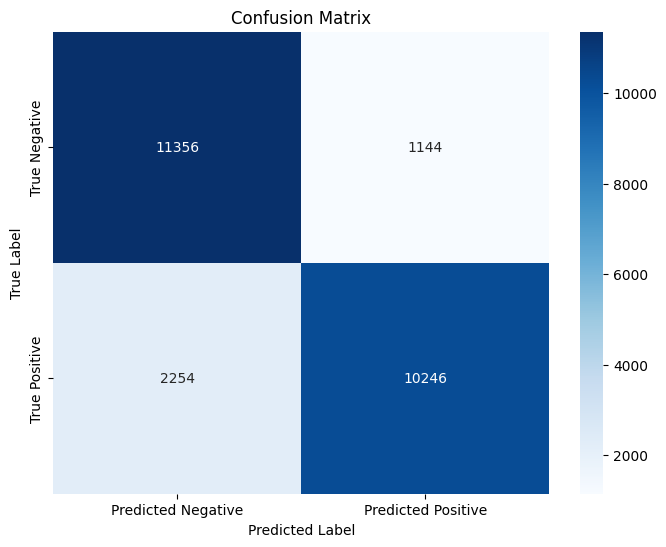

✅ Model saved as ENG_imdb_fast_model


In [3]:
# -*- coding: utf-8 -*-
"""IMDB情感分析极速训练版（Colab GPU优化）"""
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

def load_local_imdb(data_path, dataset_type='train'):
    """Load local IMDB data and check label distribution"""
    texts, labels = [], []
    for sentiment in ['pos', 'neg']:
        dir_path = os.path.join(data_path, dataset_type, sentiment)
        if not os.path.exists(dir_path):
            raise FileNotFoundError(f"Dataset path {dir_path} does not exist, please check DATA_PATH")
        file_count = 0
        for filename in os.listdir(dir_path):
            if filename.endswith('.txt'):
                with open(os.path.join(dir_path, filename), 'r', encoding='utf-8') as f:
                    content = f.read().strip()
                    if content:  # Skip empty files
                        texts.append(content)
                        labels.append(1 if sentiment == 'pos' else 0)
                        file_count += 1
        print(f"{dataset_type} dataset {sentiment} sample count: {file_count}")
    # Check label distribution
    unique, counts = np.unique(labels, return_counts=True)
    print(f"{dataset_type} dataset label distribution: {dict(zip(unique, counts))}")
    return texts, np.array(labels)

def build_vectorizer(texts, max_tokens=30000, max_len=300):
    """Build an efficient text vectorization layer"""
    vectorize_layer = TextVectorization(
        max_tokens=max_tokens,
        output_mode='int',
        output_sequence_length=max_len,
        standardize='lower_and_strip_punctuation'
    )
    vectorize_layer.adapt(texts)
    return vectorize_layer

def build_fast_model(vectorize_layer):
    """Rapid model structure"""
    model = Sequential([
        tf.keras.Input(shape=(), dtype=tf.string),
        vectorize_layer,
        Embedding(input_dim=30000, output_dim=64), # 增加嵌入维度 （源64
        Bidirectional(LSTM(64)),  #双向LSTM层，64个单元，捕获评论中的上下文信息。
        tf.keras.layers.Dropout(0.5),  # 添加Dropout层防止过拟合，丢弃率0.5，防止过拟合
        Dense(16, activation='relu'),  # 全连接层，16个单元，激活函数为ReLU
        Dense(1, activation='sigmoid')  #输出层：1个单元，sigmoid激活函数，输出0到1之间的概率（二分类）。
    ])

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-4, # 降低初始学习率
        decay_steps=2000, # 增加衰减步数
        decay_rate=0.95 # 减缓衰减速度
    )

    # 不固定学习率，使用 ExponentialDecay
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=['accuracy']
    )
    return model

def evaluate_model(model, vectorize_layer, test_texts, test_labels):
    """Comprehensive model performance evaluation"""
    # Build test dataset with raw texts and labels
    test_dataset = tf.data.Dataset.from_tensor_slices((test_texts, test_labels)).batch(256)

    print("\n=== Basic Evaluation ===")
    test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
    print(f"Test set loss: {test_loss:.4f}")
    print(f"Test set accuracy: {test_acc*100:.2f}%")

    print("\n=== Classification Report ===")
    # Predict using a dataset with only texts
    test_text_dataset = tf.data.Dataset.from_tensor_slices(test_texts).batch(256)
    y_pred = model.predict(test_text_dataset)
    y_pred = np.round(y_pred).astype(int).flatten()
    print(classification_report(test_labels, y_pred, target_names=['Negative', 'Positive']))

    print("\n=== Confusion Matrix ===")
    plt.rcParams.update(plt.rcParamsDefault) #设置默认英文字体
    cm = confusion_matrix(test_labels, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["True Negative", "True Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

def train_rapidly():
    """Rapid training process"""
    # Configuration parameters
    DATA_PATH = './aclImdb/aclImdb'  # 确保数据集在此路径
    BATCH_SIZE = 32   # 控制每轮训练次数 目前32最优解
    EPOCHS = 20  # 增加轮数，依靠EarlyStopping控制

    # Data loading
    print("🚀 Loading data...")
    train_texts, train_labels = load_local_imdb(DATA_PATH, 'train')
    test_texts, test_labels = load_local_imdb(DATA_PATH, 'test')
    print(f"Training sample count: {len(train_texts)}")  # 应为25000
    print(f"Test sample count: {len(test_texts)}")   # 应为25000

    # Text vectorization
    print("🔧 Building text processor...")
    vectorize_layer = build_vectorizer(train_texts)
    print(f"Vocabulary size: {len(vectorize_layer.get_vocabulary())}")  # 应为30000

    # Data pipeline
    train_dataset = (
        tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
        .cache()
        .shuffle(10000)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )
    test_dataset = (
        tf.data.Dataset.from_tensor_slices((test_texts, test_labels))
        .batch(BATCH_SIZE)
    )

    # Build model
    print("🛠 Building model...")
    model = build_fast_model(vectorize_layer)
    model.summary()

    # Training configuration
    callbacks = [
        EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy'),
    ]

    # Training
    print("🔥 Starting training...")
    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=EPOCHS,
        callbacks=callbacks
    )

    # Evaluation
    print("📊 Final evaluation results:")
    model.evaluate(test_dataset)
    evaluate_model(model, vectorize_layer, test_texts, test_labels)

    # Save model
    model.save('ENG_imdb_fast_model.keras')
    print("✅ Model saved as ENG_imdb_fast_model")

if __name__ == "__main__":
    print("GPU available:", tf.config.list_physical_devices('GPU'))
    train_rapidly()

In [11]:
import tensorflow as tf

# 1. Load the trained model
model_path = '/content/ENG_imdb_fast_model.keras'
model = tf.keras.models.load_model(model_path)
print("✅ Model loaded successfully")

# 2. Define sentiment prediction function
def predict_sentiment(comment):
    """
    Perform sentiment analysis on the input comment
    :param comment: str, the comment entered by the user
    :return: str, sentiment analysis result ('Positive' or 'Negative')
    """
    # Convert the comment into a format acceptable by the model
    comment_tensor = tf.constant([comment])

    # Use the model to make a prediction
    prediction = model.predict(comment_tensor)
    probability = prediction[0][0]

    # Determine sentiment based on probability
    if probability > 0.5:
        sentiment = 'Positive'
    else:
        sentiment = 'Negative'

    # Output the results
    print(f"Comment: {comment}")
    print(f"Prediction probability: {probability:.4f}")
    print(f"Sentiment: {sentiment}")
    return sentiment

# 3. Test code
if __name__ == "__main__":
    # Get the comment input from the user
    user_comment = input("Please enter your comment: ")
    predict_sentiment(user_comment)

✅ Model loaded successfully
Please enter your comment: This movei is bad
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
Comment: This movei is bad
Prediction probability: 0.1749
Sentiment: Negative


In [1]:
from google.colab import files
uploaded = files.upload()  # 上传 your_folder.zip

Saving aclImdb_v1.tar.gz to aclImdb_v1.tar.gz


In [2]:
import tarfile

# 设置压缩文件路径
gz_path = "./aclImdb_v1.tar.gz"

# 设置解压目标文件夹
extract_path = "./aclImdb"

# 解压 tar.gz 文件
with tarfile.open(gz_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

print(f"文件已解压到: {extract_path}")


文件已解压到: ./aclImdb
